In [1]:
#Import necessary packages 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
df_raw = pd.read_csv('df2.csv', index_col=0)

In [4]:
# load the dataset
df = pd.read_csv('df2.csv', index_col=0)

In [5]:
df.drop(axis='columns' , columns=['close', 'close_plus6', 'spx_close', 'spx_plus6', 'return', 'SP_return' ], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 10 to 539
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  232 non-null    int64  
 1   Product_type          232 non-null    object 
 2   Ticker                232 non-null    object 
 3   market_cap_cur        232 non-null    float64
 4   shares_out            232 non-null    float64
 5   year_inc              232 non-null    float64
 6   Previous_SBs          232 non-null    int64  
 7   Yearly_Ad_Count       232 non-null    int64  
 8   New                   232 non-null    int64  
 9   overperform           232 non-null    int64  
 10  Ave_inflation_rate    232 non-null    float64
 11  CPI                   232 non-null    float64
 12  USD_per_euro          232 non-null    float64
 13  Annual_change_GDP     232 non-null    float64
 14  VIX                   232 non-null    float64
 15  change_in_businesses  

In [6]:
df.groupby(['Product_type','New'])['overperform'].mean()

Product_type  New
Alcohol       0      0.538462
Car           0      0.282051
Clothing      0      0.333333
Film          0      0.416667
Food          0      0.560000
              1      0.625000
Gaming        0      1.000000
Goods         0      0.437500
              1      0.000000
Service       0      0.555556
              1      0.600000
Soft drink    0      0.600000
              1      1.000000
TV            0      0.714286
Technology    0      0.400000
              1      0.000000
Website       0      0.363636
              1      0.000000
Wireless      0      0.333333
Name: overperform, dtype: float64

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# Split the data
X = df.drop('overperform',axis=1)
y = df['overperform']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=714)

In [9]:
# pick transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [10]:
# split columns into numeric and categorical
numeric_features = ['Year', 'market_cap_cur', 'shares_out', 'year_inc', 'Previous_SBs', 'Yearly_Ad_Count','New', 'Ave_inflation_rate', 'CPI','USD_per_euro', 'Annual_change_GDP','VIX','change_in_businesses']
categorical_features = ['Product_type', 'Ticker']
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

### Logistic Regression

In [11]:
C_params = [0.001,0.01,0.1,1,10,100,1000, 1000000]

In [12]:
# loop through C_params
j = 0

table = pd.DataFrame(columns = ['C','Recall','Precision','ROC-AOC'])
table['C'] = C_params
for C in C_params:
    
    # Apply logistic regression model to training data
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',LogisticRegression(C=C,random_state=42))
           ])
    lr_model = pipeline.fit(X_train, y_train) 
    predictions = lr_model.predict(X_test)
    probs = pipeline.predict_proba(X_test)[:, 1]
    # Predict using model
    #print('C is ',C)
    #print ('Recall: ',metrics.recall_score(y_test, predictions) )
    #print ('Precision: ',metrics.precision_score(y_test, predictions) )
    print (confusion_matrix(y_test, predictions))
    #print ('AOC: ',metrics.roc_auc_score(y, probs))
    table.iloc[j,1] = metrics.recall_score(y_test, predictions)
    table.iloc[j,2] = metrics.precision_score(y_test, predictions)
    table.iloc[j,3] = metrics.roc_auc_score(y_test, probs)
    j+=1
table



[[27  0]
 [20  0]]
[[24  3]
 [17  3]]
[[22  5]
 [16  4]]
[[22  5]
 [13  7]]
[[22  5]
 [14  6]]
[[22  5]
 [15  5]]
[[23  4]
 [15  5]]
[[23  4]
 [15  5]]


,C,Recall,Precision,ROC-AOC
0,0.001,0.0,0.0,0.514815
1,0.010,0.15,0.5,0.507407
2,0.100,0.2,0.444444,0.555556
3,1.000,0.35,0.583333,0.583333
4,10.000,0.3,0.545455,0.596296
5,100.000,0.25,0.5,0.605556
6,1000.000,0.25,0.555556,0.574074
7,1000000.000,0.25,0.555556,0.588889


Looks like decreasing penalties improves the model. If this ends up near the top this should come out in GridSearch

In [13]:
cv_scores_test= cross_val_score(lr_model,X_test,y_test,cv=4,scoring='roc_auc')
cv_scores_train= cross_val_score(lr_model,X_train,y_train,cv=4,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_precision_lr_test = cross_val_score(lr_model,X_test,y_test,cv=4,scoring='precision').mean()
cv_recall_lr_test = cross_val_score(lr_model,X_test,y_test,cv=4,scoring='recall').mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_lr = cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_lr))


[0.34285714 0.65714286 0.51428571 0.53333333]
Mean cross validation test score: 0.5119047619047619
Mean cross validation train score: 0.6091575091575092
Standard deviation in cv test scores: 0.11195540900484524


In [14]:
table = pd.DataFrame(columns = ['Model','Recall','Precision','ROC-AOC'])
table[['Model','Recall','Precision','ROC-AOC']] = [['Logistic Regression', cv_recall_lr_test, cv_precision_lr_test , cv_scores_lr_test]]
table

,Model,Recall,Precision,ROC-AOC
0,Logistic Regression,0.5,0.441667,0.511905


Not really looking that good with the large difference between training and test

## KNN

In [15]:
# Reset the pipeline and try KNN
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', KNeighborsClassifier(p=2,weights='distance',n_neighbors=6))
           ])

knn = pipeline.fit(X_train,y_train)

# Predict using model:

y_predict_knn = pipeline.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)

[[22  5]
 [12  8]]


In [16]:
cv_scores_test= cross_val_score(pipeline,X_test,y_test,cv=4,scoring='roc_auc')
cv_scores_train= cross_val_score(pipeline,X_train,y_train,cv=4,scoring='roc_auc')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_precision_knn_test = cross_val_score(pipeline, X_test,y_test,cv=4,scoring='precision').mean()
cv_recall_knn_test = cross_val_score(pipeline, X_test,y_test,cv=4,scoring='recall').mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_knn_test))
print ('Mean cross validation train score: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_knn))


[0.77142857 0.62857143 0.45714286 0.83333333]
Mean cross validation test score: 0.6726190476190476
Mean cross validation train score: 0.5104510073260073
Standard deviation in cv scores: 0.14488149039302228


In [17]:
j=1
table.loc[j] = ['KNN', cv_recall_knn_test, cv_precision_knn_test , cv_scores_knn_test]
print(table)
j+=1

                 Model Recall Precision   ROC-AOC
0  Logistic Regression    0.5  0.441667  0.511905
1                  KNN   0.45  0.641667  0.672619


### Something seems strange here with an outlier model

Good choice to gridsearch?

## SVM

In [87]:
from sklearn.svm import SVC
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', SVC(kernel='linear'))
           ])
svm = pipeline.fit(X_train, y_train)

# Predict using model:

y_predict_svm = pipeline.predict(X_test)
#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)


[[22  5]
 [14  6]]


In [90]:
cv_scores_test= cross_val_score(pipeline,X_test,y_test,cv=4,scoring='roc_auc')
cv_scores_train= cross_val_score(pipeline,X_train,y_train,cv=4,scoring='roc_auc')
print(cv_scores_test)
cv_scores_svm_test= cv_scores_test.mean()
cv_precision_svm_test = cross_val_score(pipeline, X_test,y_test,cv=4,scoring='precision').mean()
cv_recall_svm_test = cross_val_score(pipeline, X_test,y_test,cv=4,scoring='recall').mean()
cv_scores_svm_train= cv_scores_train.mean()
cv_scores_std_svm= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_svm))

[0.62857143 0.62857143 0.42857143 0.83333333]
Mean cross validation test score: 0.6297619047619047
Mean cross validation train score: 0.5938415750915751
Standard deviation in cv scores: 0.1431098954540557


In [91]:
table.loc[j] = ['SVM', cv_recall_svm_test, cv_precision_svm_test , cv_scores_svm_test]
print(table)
j+=1

                 Model Recall Precision ROC-AOC
0  Logistic Regression    0.5    0.4417  0.5119
1                  KNN   0.45    0.6417  0.6726
2                  SVM    0.6    0.6083  0.6233
3        Random Forest    0.4     0.475  0.5286
4    Gradient Boosting   0.35    0.5083  0.5726
5                  SVM    0.6    0.6083  0.6298


Again there seem to be cuts that perform badly

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', RandomForestClassifier(bootstrap=True,n_estimators=40,criterion='entropy', max_depth=4))
           ])
rf = pipeline.fit(X_train, y_train)


#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)


[[22  5]
 [15  5]]
0.574468085106383


In [22]:
rf['regressor'].feature_importances_

array([0.02580614, 0.04588542, 0.0444811 , 0.08551163, 0.03077935,
       0.02456176, 0.00814042, 0.04812261, 0.05613158, 0.04700774,
       0.08463369, 0.0711452 , 0.08981666, 0.        , 0.01207661,
       0.00706823, 0.00520275, 0.00921811, 0.        , 0.00863687,
       0.00613302, 0.01187422, 0.0126243 , 0.00150321, 0.01975446,
       0.01711534, 0.00239322, 0.        , 0.00287581, 0.00300757,
       0.00189809, 0.        , 0.00180823, 0.01048181, 0.        ,
       0.        , 0.00859463, 0.        , 0.00116406, 0.00071771,
       0.0009927 , 0.00151197, 0.00110931, 0.00356223, 0.00756673,
       0.00274032, 0.00488908, 0.00847382, 0.        , 0.00360986,
       0.0019375 , 0.        , 0.        , 0.        , 0.        ,
       0.00352835, 0.        , 0.00316731, 0.        , 0.        ,
       0.00303952, 0.00081692, 0.00061892, 0.        , 0.00114006,
       0.00568888, 0.        , 0.00199975, 0.00486629, 0.0090647 ,
       0.00449924, 0.00108632, 0.        , 0.        , 0.     

In [23]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=4,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=4,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_precision_rf_test = cross_val_score(rf, X_test,y_test,cv=4,scoring='precision').mean()
cv_recall_rf_test = cross_val_score(rf, X_test,y_test,cv=4,scoring='recall').mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.54285714 0.54285714 0.42857143 0.6       ]
Mean cross validation test score: 0.5285714285714287
Mean cross validation train score: 0.5798763736263737
Standard deviation in cv scores: 0.062269984907723924


In [24]:
table.loc[j] = ['Random Forest', cv_recall_rf_test, cv_precision_rf_test , cv_scores_rf_test]
print(table)
j+=1

                 Model Recall Precision   ROC-AOC
0  Logistic Regression    0.5  0.441667  0.511905
1                  KNN   0.45  0.641667  0.672619
2                  SVM    0.6  0.608333  0.623333
3        Random Forest    0.4     0.475  0.528571


RF seems far more consistent but performs generally worse. Average with it maybe?

## Gradient Boosting

In [25]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GradientBoostingClassifier(subsample=0.8, learning_rate=0.01 , n_estimators=100, random_state=5, max_depth=4, max_leaf_nodes=30))
           ])
gbc = pipeline.fit(X_train, y_train)

#Predict using the model:

y_predict_gbc = gbc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)
Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

[[22  5]
 [12  8]]
0.6382978723404256


In [26]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=4,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=4,scoring='roc_auc')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_precision_gbc_test = cross_val_score(gbc, X_test,y_test,cv=4,scoring='precision').mean()
cv_recall_gbc_test = cross_val_score(gbc, X_test,y_test,cv=4,scoring='recall').mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.4        0.6        0.65714286 0.63333333]
Mean cross validation test score: 0.5726190476190476
Mean cross validation train score: 0.582257326007326
Standard deviation in cv scores: 0.1017073633278439


In [27]:
table.loc[j] = ['Gradient Boosting', cv_recall_gbc_test, cv_precision_gbc_test , cv_scores_gbc_test]
print(table)
j+=1

                 Model Recall Precision   ROC-AOC
0  Logistic Regression    0.5  0.441667  0.511905
1                  KNN   0.45  0.641667  0.672619
2                  SVM    0.6  0.608333  0.623333
3        Random Forest    0.4     0.475  0.528571
4    Gradient Boosting   0.35  0.508333  0.572619


In [28]:
table

,Model,Recall,Precision,ROC-AOC
0,Logistic Regression,0.5,0.441667,0.511905
1,KNN,0.45,0.641667,0.672619
2,SVM,0.6,0.608333,0.623333
3,Random Forest,0.4,0.475,0.528571
4,Gradient Boosting,0.35,0.508333,0.572619


## Compare Models
First let's see what we have so far.

In [29]:
myLabels = [ 'Logistic Regression','KNN','SVM','Random Forest','Gradient Boost']
score_test= [  cv_scores_lr_test,cv_scores_knn_test,cv_scores_svm_test,cv_scores_rf_test,cv_scores_gbc_test]
score_train= [  cv_scores_lr_train,cv_scores_knn_train,cv_scores_svm_train,cv_scores_rf_train,cv_scores_gbc_train]
std_test= [  cv_scores_std_lr,cv_scores_std_knn,cv_scores_std_svm,cv_scores_std_rf,cv_scores_std_gbc]

#score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               #columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test, std_test, table.Recall, table.Precision)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score',  'ROC-AUC test std', 'Recall test', 'Precision test']) 
#print(score_tab_acc)

score_tab

,Algorithm,ROC-AUC train score,ROC-AUC test score,ROC-AUC test std,Recall test,Precision test
0,Logistic Regression,0.609158,0.511905,0.111955,0.50,0.441667
1,KNN,0.510451,0.672619,0.144881,0.45,0.641667
2,SVM,0.575399,0.623333,0.138484,0.60,0.608333
3,Random Forest,0.579876,0.528571,0.062270,0.40,0.475000
4,Gradient Boost,0.582257,0.572619,0.101707,0.35,0.508333


It's hard to see what will work best here but Random Forest seems like a good possibility. 
The only one not looking so good is Logistic Regression. 
First GridSearch on Random Forest

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'max_depth': [4, 5, 6, None],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 1000]}
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(RandomForestClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.6111111111111112

In [31]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)
print(pipeline['regressor'])

RandomForestClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=10)
0.6225503663003663
GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, None],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400, 1000]},
             scoring='roc_auc')


In [32]:
# Try again with scoring as Recall
param_grid = { 'max_depth': [4, 5, 6, None],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 1000]}
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(RandomForestClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='recall', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.3

In [33]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

RandomForestClassifier(min_samples_split=10)
0.481547619047619


In [34]:
param_grid = { 'C': [1, 10], 
          'gamma': [0.001, 0.01, 1]}
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(SVC(kernel='linear'), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)


0.5851851851851853

In [35]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)
print(pipeline['regressor'])

SVC(C=1, gamma=0.001, kernel='linear')
0.5943223443223443
GridSearchCV(cv=4, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': [0.001, 0.01, 1]},
             scoring='roc_auc')


In [36]:
param_grid = { 'C': [1, 10], 
          'gamma': [0.001, 0.01, 1]}
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(SVC(kernel='linear'), cv=4, n_jobs=-1, param_grid=param_grid , scoring='recall', refit=True))
           ])




pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.35

In [37]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

SVC(C=10, gamma=0.001, kernel='linear')
0.5059523809523809


SVC does not look better.
Next is Gradient Boosting.

In [38]:
param_grid = { 'max_depth': [4, 5, 6, None],
 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10, 20],
 'n_estimators': [10, 40, 100]}
pipeline =  Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(GradientBoostingClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])



pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.6481481481481481

In [39]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)
print(pipeline['regressor'])

GradientBoostingClassifier(learning_rate=0.01, max_depth=6, min_samples_leaf=4,
                           min_samples_split=20, n_estimators=40)
0.6326350732600734
GridSearchCV(cv=4, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                           0.2],
                         'max_depth': [4, 5, 6, None],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [10, 40, 100]},
             scoring='roc_auc')


In [40]:
param_grid = { 'max_depth': [4, 5, 6, None],
 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10, 20],
 'n_estimators': [10, 40, 100]}
pipeline =  Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(GradientBoostingClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='recall', refit=True))
           ])



pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.4

In [41]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

GradientBoostingClassifier(learning_rate=0.15, max_depth=6, min_samples_leaf=6,
                           min_samples_split=10, n_estimators=40)
0.594047619047619


Not suprisingly this turns out very close to Random Forest. 
Just to be thorough lets tune KNN

In [42]:
param_grid = { 'n_neighbors': [3, 5, 7, 9, 12,15,17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
pipeline =  Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(KNeighborsClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='roc_auc', refit=True))
           ])



pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.6518518518518519

In [43]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)
print(pipeline['regressor'])

KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')
0.6128891941391941
GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 12, 15, 17],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')


In [44]:
param_grid = { 'n_neighbors': [3, 5, 7, 9, 12,15,17],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}
pipeline =  Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor',  GridSearchCV(KNeighborsClassifier(), cv=4, n_jobs=-1, param_grid=param_grid , scoring='recall', refit=True))
           ])



pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.4

In [45]:
print(pipeline['regressor'].best_estimator_) 
print(pipeline['regressor'].best_score_)

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
0.469047619047619


### Fit RF ,  GB and KNN
Random Forest first.


In [46]:
# AOC scoring 
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', RandomForestClassifier(min_samples_leaf=4, min_samples_split=5))
           ])
rf = pipeline.fit(X_train, y_train)

y_predictions_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_predictions_rf)
cv_scores_rf_test = cross_val_score(rf, X_test, y_test,scoring='roc_auc').mean()
cv_scores_std_rf = cross_val_score(rf, X_test, y_test, scoring='roc_auc').std()
cv_recall_rf = cross_val_score(rf, X_test, y_test,scoring='recall').mean()
print("Accuracy: ", acc)
cv_rf = cross_val_score(rf, X_test, y_test,scoring='roc_auc')
print("Recall: ", cv_recall_rf)
print("ROC-AUC", cv_scores_rf_test)

Accuracy:  0.5957446808510638
Recall:  0.25
ROC-AUC 0.5566666666666666


In [47]:
feature_names = rf[:-1].get_feature_names_out()
mdi_importances = pd.Series(rf[-1].feature_importances_, index=feature_names).sort_values(ascending=True)
mdi_imp = mdi_importances.tail(16)


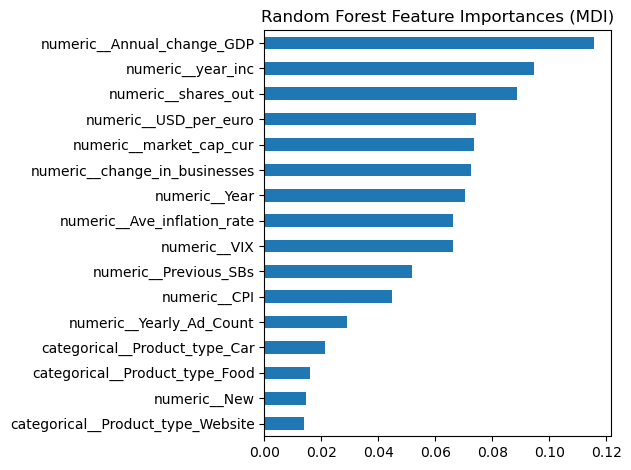

In [48]:
ax = mdi_imp.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [49]:
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.6611111111111111


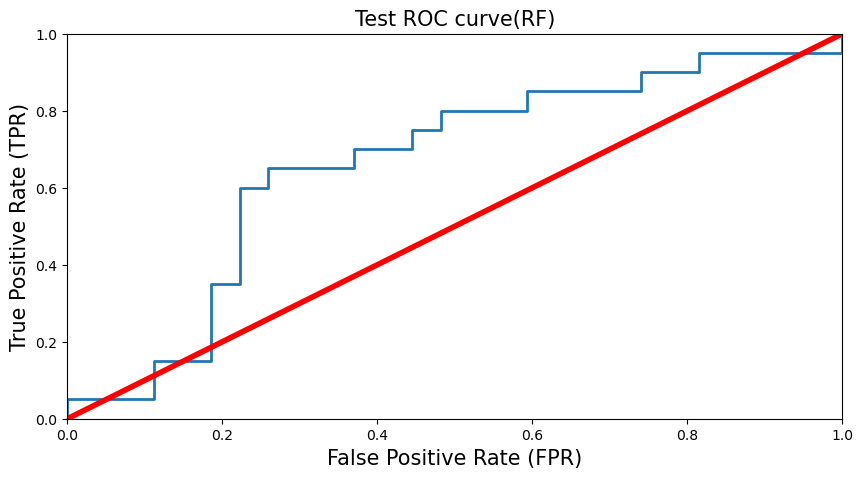

In [50]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.title('Test ROC curve(RF)',fontsize=15)
plt.savefig("30.png")
plt.show()

### Next Gradient Boosting

In [51]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', GradientBoostingClassifier(learning_rate=0.01, max_depth=6, min_samples_leaf=4,
                           min_samples_split=20, n_estimators=40))
           ])
gb = pipeline.fit(X_train, y_train)

y_predictions_gb = gb.predict(X_test)
acc = accuracy_score(y_test, y_predictions_gb)
cv_scores_gb_test = cross_val_score(gb, X_test, y_test,scoring='roc_auc').mean()
cv_scores_std_gb = cross_val_score(gb, X_test, y_test, scoring='roc_auc').std()
cv_recall_gb = cross_val_score(gb, X_test, y_test,scoring='recall').mean()
print("Accuracy: ", acc)
cv_rf = cross_val_score(gb, X_test, y_test,scoring='roc_auc')
print("Recall: ", cv_recall_gb)
print("ROC-AUC", cv_scores_gb_test)

Accuracy:  0.6170212765957447
Recall:  0.25
ROC-AUC 0.4699999999999999


In [52]:
feature_names = gb[:-1].get_feature_names_out()
mdi_importances = pd.Series(gb[-1].feature_importances_, index=feature_names).sort_values(ascending=True)
mdi_imp = mdi_importances.tail(16)

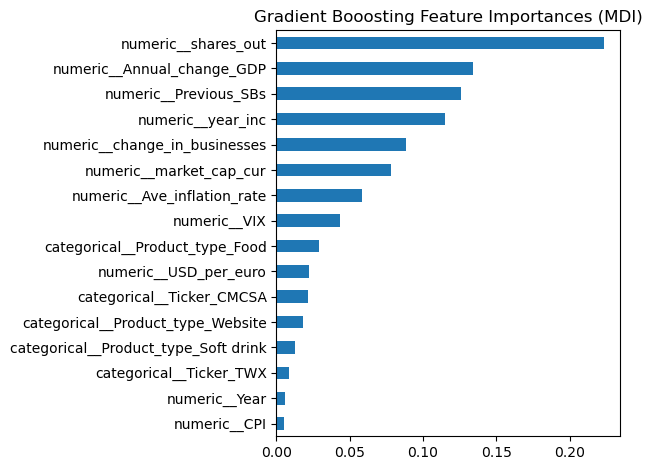

In [53]:
ax = mdi_imp.plot.barh()
ax.set_title("Gradient Booosting Feature Importances (MDI)")
ax.figure.tight_layout()

In [54]:
y_scores_gb = gb.predict_proba(X_test)
y_scores_gb = y_scores_gb[:,1]
auroc = roc_auc_score(y_test, y_scores_gb)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.6481481481481481


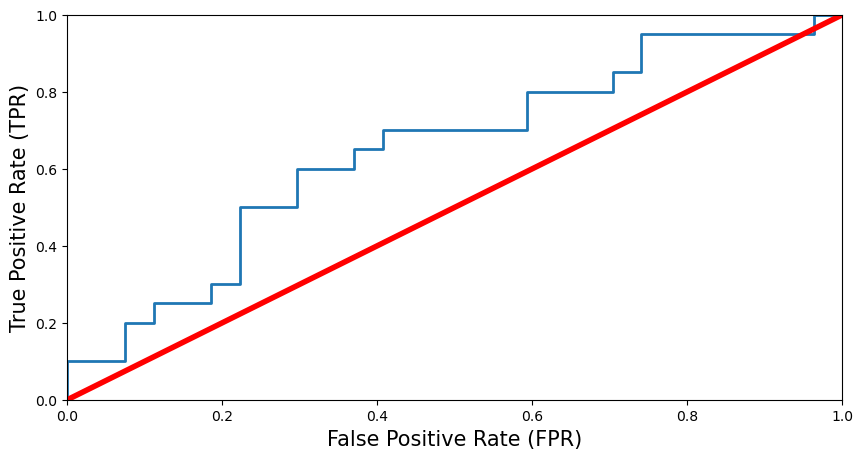

In [55]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("gb_aoc.png")
plt.show()

KNN

In [56]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance'))
           ])
knn = pipeline.fit(X_train, y_train)

y_predictions_knn = knn.predict(X_test)
acc = accuracy_score(y_test, y_predictions_knn)
cv_scores_knn_test = cross_val_score(knn, X_test, y_test, scoring='roc_auc').mean() 
cv_scores_std_knn = cross_val_score(knn, X_test, y_test, scoring='roc_auc').std()
print(acc)
cv_knn = cross_val_score(knn, X_test, y_test, scoring='roc_auc')
print(cv_knn)

0.574468085106383
[0.58333333 0.375      0.55       0.75       0.45      ]


In [57]:
y_scores_knn = knn.predict_proba(X_test)
y_scores_knn = y_scores_knn[:,1]
auroc = roc_auc_score(y_test, y_scores_knn)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.6518518518518519


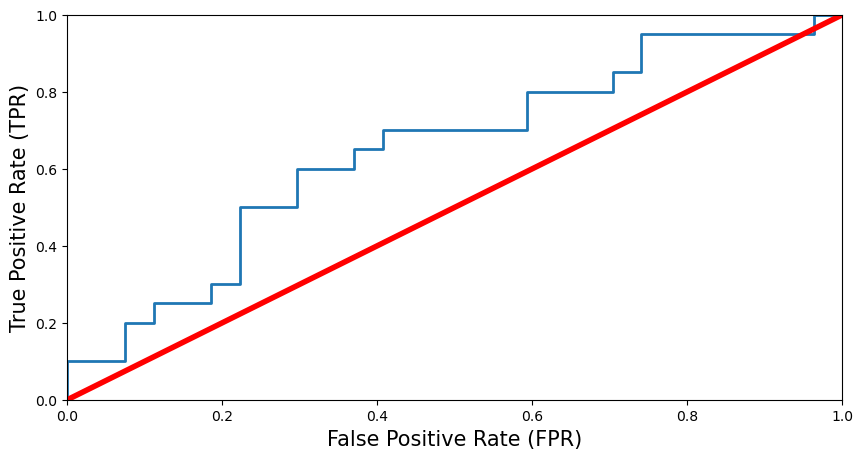

In [58]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_gb)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("gb_aoc.png")
plt.show()

In [59]:
myLabels = [ 'KNN','Random Forest','Gradient Boost']
score_test= [  cv_scores_knn_test,cv_scores_rf_test,cv_scores_gb_test]
#score_train= [  cv_scores_knn_train,cv_scores_rf_train,cv_scores_gb_train]
std_test= [ cv_scores_std_knn,cv_scores_std_rf,cv_scores_std_gb]

#score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               #columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_test, std_test)), 
               columns =['Algorithm',  'ROC-AUC test score',  'ROC-AUC test std']) 
#print(score_tab_acc)

score_tab

,Algorithm,ROC-AUC test score,ROC-AUC test std
0,KNN,0.541667,0.127584
1,Random Forest,0.556667,0.122543
2,Gradient Boost,0.470000,0.106177


### Run the model on the full set

In [60]:
#Final prediction RF:
y_preds_rf = rf.predict(X)
target = pd.Series(y_preds_rf, name='Overperform')
ticker = df['Ticker']
year = df['Year']
actual = df['overperform']
prod_type = df['Product_type']
rateofreturn = df_raw['return']
output = pd.DataFrame(list(zip(ticker, year, prod_type, target, actual, rateofreturn,)), 
               columns =['Ticker', 'Year', 'Product Type', 'Overperform', 'Actual', 'Return']) 




output.to_csv('final_result_rf.csv', index=False, header=True)

In [61]:
# Model predicts incorrectly
print(output[output['Overperform']!=output['Actual']].groupby('Year').count())
print(output[output['Overperform']!=output['Actual']].groupby('Product Type').count())

      Ticker  Product Type  Overperform  Actual  Return
Year                                                   
1993       2             2            2       2       2
1997       3             3            3       3       3
1998       3             3            3       3       3
1999       2             2            2       2       2
2000       1             1            1       1       1
2001       1             1            1       1       1
2002       1             1            1       1       1
2004       2             2            2       2       2
2005       1             1            1       1       1
2006       1             1            1       1       1
2008       2             2            2       2       2
2009       4             4            4       4       4
2010       5             5            5       5       5
2011       1             1            1       1       1
2012       1             1            1       1       1
2013       2             2            2       2 

In [62]:
# Model predicts correctly
print(output[output['Overperform'] == output['Actual']].groupby('Year').count())
print(output[output['Overperform'] == output['Actual']].groupby('Product Type').count())

      Ticker  Product Type  Overperform  Actual  Return
Year                                                   
1984       1             1            1       1       1
1988       1             1            1       1       1
1990       2             2            2       2       2
1992       1             1            1       1       1
1993       2             2            2       2       2
1996       1             1            1       1       1
1997       1             1            1       1       1
1998       7             7            7       7       7
1999       6             6            6       6       6
2000       7             7            7       7       7
2001       5             5            5       5       5
2002       5             5            5       5       5
2003       4             4            4       4       4
2004       4             4            4       4       4
2005       8             8            8       8       8
2006       2             2            2       2 

In [63]:
#  model falsely predicts overperformance
print(output[(output['Actual']==0) & (output['Overperform']==1)].groupby('Year').count())
print(output[(output['Actual']==0) & (output['Overperform']==1)].groupby('Product Type').count())

      Ticker  Product Type  Overperform  Actual  Return
Year                                                   
2009       3             3            3       3       3
2010       5             5            5       5       5
2012       1             1            1       1       1
2015       4             4            4       4       4
2019       1             1            1       1       1
              Ticker  Year  Overperform  Actual  Return
Product Type                                           
Alcohol            1     1            1       1       1
Car                1     1            1       1       1
Film               3     3            3       3       3
Food               1     1            1       1       1
Goods              3     3            3       3       3
Service            2     2            2       2       2
TV                 1     1            1       1       1
Website            2     2            2       2       2


In [64]:
# model fails to predict actual overperformance
print(output[(output['Actual']==1) & (output['Overperform']==0)].groupby('Year').count())
print(output[(output['Actual']==1) & (output['Overperform']==0)].groupby('Product Type').count())

      Ticker  Product Type  Overperform  Actual  Return
Year                                                   
1993       2             2            2       2       2
1997       3             3            3       3       3
1998       3             3            3       3       3
1999       2             2            2       2       2
2000       1             1            1       1       1
2001       1             1            1       1       1
2002       1             1            1       1       1
2004       2             2            2       2       2
2005       1             1            1       1       1
2006       1             1            1       1       1
2008       2             2            2       2       2
2009       1             1            1       1       1
2011       1             1            1       1       1
2013       2             2            2       2       2
2015       4             4            4       4       4
2017       5             5            5       5 

In [65]:
confusion_matrix(y , y_preds_rf)

array([[117,  14],
       [ 44,  57]], dtype=int64)

In [66]:
print(classification_report(y, y_preds_rf))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       131
           1       0.80      0.56      0.66       101

    accuracy                           0.75       232
   macro avg       0.76      0.73      0.73       232
weighted avg       0.76      0.75      0.74       232



In [67]:
# test classification report
y_preds_rf_test = rf.predict(X_test)
print(classification_report(y_test, y_preds_rf_test))
confusion_matrix(y_test, y_preds_rf_test)

              precision    recall  f1-score   support

           0       0.61      0.81      0.70        27
           1       0.55      0.30      0.39        20

    accuracy                           0.60        47
   macro avg       0.58      0.56      0.54        47
weighted avg       0.58      0.60      0.57        47



array([[22,  5],
       [14,  6]], dtype=int64)

In [68]:
y_scores_rf_full = rf.predict_proba(X)
y_scores_rf_full = y_scores_rf_full[:,1]

<Figure size 1000x500 with 0 Axes>

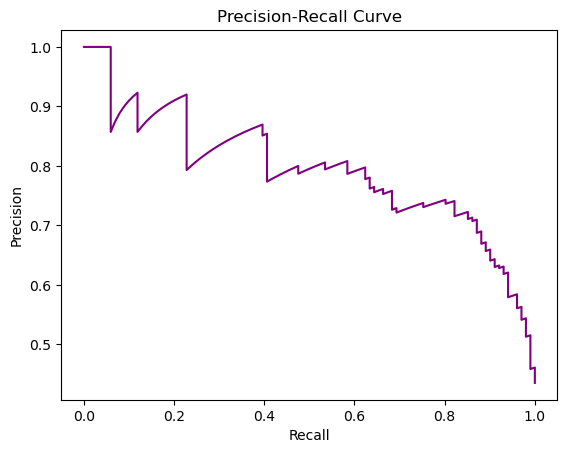

In [69]:
precision, recall, thresholds = precision_recall_curve(y, y_scores_rf_full)
def plot_pr_curve(precision, recall, label=None):
    #create precision recall curve
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')

    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')




plt.figure(figsize=(10, 5))
plot_pr_curve(precision, recall)
plt.savefig("pr_rf.png")
plt.show()

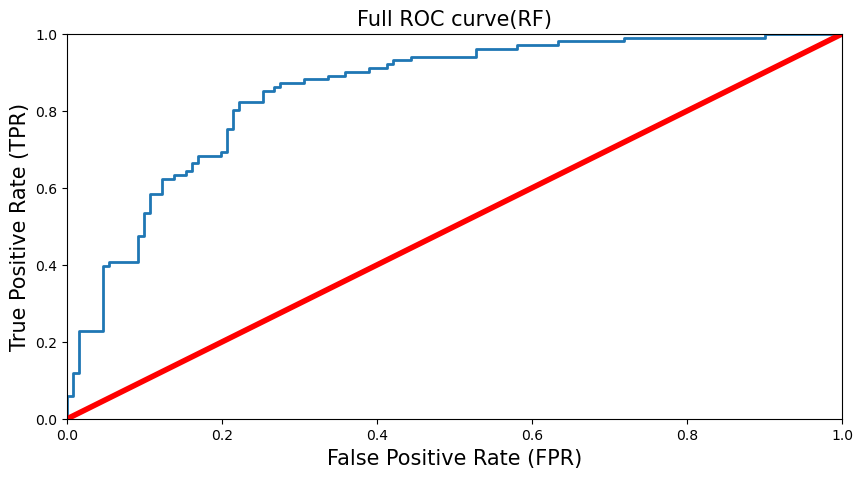

In [70]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_scores_rf_full)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.title('Full ROC curve(RF)',fontsize=15)
plt.savefig("rf_full_aoc.png")
plt.show()

In [71]:
pd.set_option('display.precision', 4)

In [72]:
# Create comparison of returns 
# first find the return of picking all the advertisers
dummy_ave_ret = output['Return'].groupby(output['Year']).mean()
print(dummy_ave_ret)
# use the model
model_ave_ret = output['Return'][output['Overperform']==1].groupby(output['Year']).mean()
print(model_ave_ret)
sandp_ave_ret = df_raw['SP_return'].groupby(df_raw['Year'])
print(sandp_ave_ret)

Year
1984   -0.1538
1988    0.1022
1990   -0.1466
1992    0.1028
1993   -0.0669
1996   -0.0893
1997    0.2665
1998    0.1416
1999   -0.0128
2000   -0.4469
2001   -0.1605
2002   -0.1612
2003    0.0953
2004   -0.0112
2005   -0.0856
2006   -0.0599
2008   -0.1623
2009    0.2864
2010    0.1484
2011   -0.2123
2012    0.0752
2013    0.2774
2014    0.1819
2015    0.1178
2016    0.1120
2017    0.1216
2018    0.0475
2019    0.0552
2020   -0.0783
Name: Return, dtype: float64
Year
1988    0.1022
1992    0.1028
1999    0.0515
2001    0.2441
2002   -0.0134
2003    0.2616
2004    0.0655
2008   -0.0224
2009    0.2860
2010    0.1564
2011   -0.0495
2012    0.1392
2013    0.2595
2014    0.2228
2015    0.2265
2016    0.2461
2017    0.1915
2018    0.3161
2019    0.1006
Name: Return, dtype: float64


In [73]:
sandp_ave_ret = df_raw['SP_return'].groupby(df_raw['Year']).mean()
print(sandp_ave_ret)

Year
1984    0.1365
1988   -0.2104
1990    0.0933
1992   -0.0064
1993    0.0172
1996    0.0107
1997    0.2241
1998    0.1989
1999    0.0432
2000    0.0261
2001   -0.1170
2002   -0.2374
2003    0.1759
2004   -0.0252
2005    0.0178
2006    0.0085
2008   -0.0955
2009    0.2147
2010    0.0672
2011   -0.1513
2012    0.0371
2013    0.1414
2014    0.1132
2015    0.0382
2016    0.1767
2017    0.0822
2018    0.0761
2019    0.0440
2020    0.0141
Name: SP_return, dtype: float64


In [74]:
new = pd.DataFrame(list(zip(dummy_ave_ret, sandp_ave_ret)), 
               columns =[ 'Pick All', 'S and P'], index=dummy_ave_ret.index) 
model_df = pd.DataFrame(list(zip(model_ave_ret)), 
               columns =['Model'], index=model_ave_ret.index) 
return_results = new.merge(model_df, left_index=True, right_index=True, how='left')
return_results['Model-PickAll'] = return_results['Model']-return_results['Pick All']
return_results['Model-SP'] = return_results['Model']-return_results['S and P']
return_results['PickAll-SP'] = return_results['Pick All']-return_results['S and P']

In [75]:
print('The average return of the model is : {:.2%}'.format(return_results['Model'].mean()))
print('The average return of the S & P those years is : {:.2%}'.format(return_results[return_results['Model'].notna()]['S and P'].mean()))
print('The average return of the Pick All those years is : {:.2%}'.format(return_results[return_results['Model'].notna()]['Pick All'].mean()))

The average return of the model is : 15.19%
The average return of the S & P those years is : 1.93%
The average return of the Pick All those years is : 5.28%


In [76]:
# model does not beat pick all
return_results[return_results['Model-PickAll']<0]

,Pick All,S and P,Model,Model-PickAll,Model-SP,PickAll-SP
Year,,,,,,
2009,0.2864,0.2147,0.2860,-0.0004,0.0713,0.0718
2013,0.2774,0.1414,0.2595,-0.0179,0.1182,0.1360


In [77]:
# model does not beat S and P
return_results[return_results['Model-SP']<0]

,Pick All,S and P,Model,Model-PickAll,Model-SP,PickAll-SP
Year,,,,,,


In [78]:
# model beats pickall by 10 %age points
print('The model beat picking all the stocks by 5 percentage points ', return_results[return_results['Model-PickAll'] > .05].Model.count(), ' times')

The model beat picking all the stocks by 5 percentage points  12  times


In [79]:
print('The model beat the S & P 500 by 5 percentage points ' , return_results[return_results['Model-SP']> .05].Model.count(), ' times.')

The model beat the S & P 500 by 5 percentage points  18  times.


In [80]:
print('The model did not predict any overperformers in these years ',list(return_results[return_results['Model'].isna()].index))

The model did not predict any overperformers in these years  [1984, 1990, 1993, 1996, 1997, 1998, 2000, 2005, 2006, 2020]


In [81]:
return_results[(return_results['Model'].isna()) & (return_results.index > 1998)][['S and P', 'Pick All', 'PickAll-SP']].style.format({'S and P': "{:.1%}", 'Pick All': "{:.1%}", 'PickAll-SP': "{:.1%}"})

,S and P,Pick All,PickAll-SP
Year,,,
2000,2.6%,-44.7%,-47.3%
2005,1.8%,-8.6%,-10.3%
2006,0.8%,-6.0%,-6.8%
2020,1.4%,-7.8%,-9.2%


In [82]:
pickall_beats_sp = return_results[return_results['PickAll-SP']>0]['Pick All'].count()
pickall_loses_sp = return_results[return_results['PickAll-SP']<0]['Pick All'].count()
total_years = pickall_beats_sp + pickall_loses_sp

In [ ]:
print('The original idea of picking all the Super Bowl Advervisors only beats the S & P 500 ', pickall_beats_sp, ' out of ', total_years ,' years.')

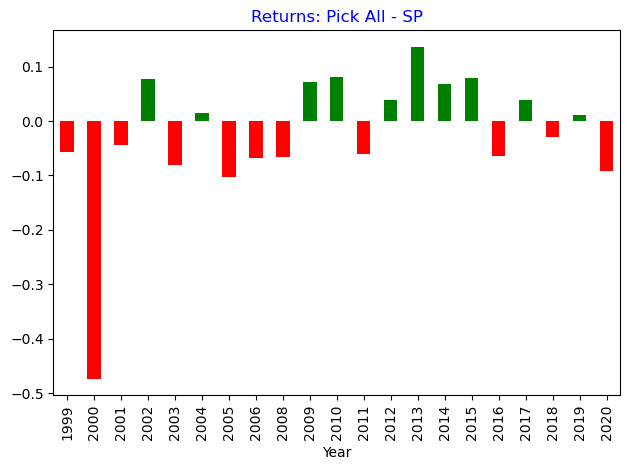

In [84]:
# bar graph of PickAll - SP
colors = ['g' if e >= 0 else 'r' for e in return_results[return_results.index > 1998]['PickAll-SP']]
ax = return_results[return_results.index > 1998]['PickAll-SP'].plot.bar(color=colors)
ax.set_title("Returns: Pick All - SP", color='b')
ax.figure.tight_layout()

In [85]:
return_results1 = return_results[(return_results.index > 1998) &  (return_results['Model'].notna())]

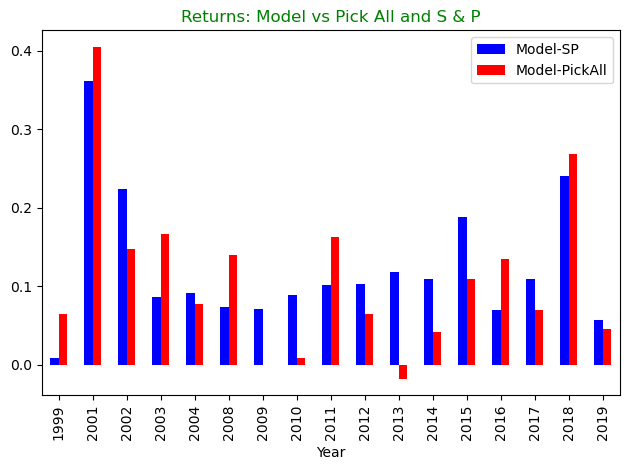

In [86]:
# bar graph of Model - SP
ax = return_results1[['Model-SP', 'Model-PickAll']].plot.bar(color=['b','r'])
ax.set_title("Returns: Model vs Pick All and S & P", c='g')
ax.figure.tight_layout()